In [16]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

# TODO add .env file
import os
import sys

SEED = 42

tffm_path = '../'
print('Add path : ', os.listdir(tffm_path))
sys.path.append(tffm_path)
print()
print('path pacakge path : ', sys.path)

Add path :  ['.DS_Store', 'LICENSE', 'gpu_benchmark.ipynb', 'test.py', 'README.md', 'example.ipynb', 'yltsai', 'setup.py', '.gitignore', 'tffm', 'setup.cfg', '.ipynb_checkpoints', '.git']

path pacakge path :  ['/Users/YuLong/Desktop/Working_Area/recsys_im/tffm/yltsai', '/usr/local/spark/python', '/Users/YuLong/Desktop/Working_Area/recsys_im/tffm/yltsai', '/Users/YuLong/miniconda3/envs/py_37_ds/lib/python37.zip', '/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7', '/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/lib-dynload', '', '/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages', '/Users/YuLong/Desktop/Working_Area/DataScience_Note/demo/packaging', '/Users/YuLong/Desktop/Working_Area/pose_recognition', '/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/IPython/extensions', '/Users/YuLong/.ipython', '../', '../', '../']


# Load data

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

print('-----END IMPORT MESSAGE------ \n\n\n')

# dataset = fetch_openml("mnist_784")
mnist = input_data.read_data_sets("MNIST_data/")

mnist_images = mnist.train.images
mnist_labels = mnist.train.labels

n_three, n_five = sum(mnist_labels==3), sum(mnist_labels==5)

X_all = np.vstack([
    mnist_images[mnist_labels==3,:],
    mnist_images[mnist_labels==5,:]
])

y_all = np.array([1] * n_three + [0] * n_five)
# make it more sparse
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.8)


print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {:.05f}'.format(np.mean(X_all != 0)))
print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

-----END IMPORT MESSAGE------ 



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Dataset shape: (10625, 784)
Non-zeros rate: 0.04029
Classes balance: 0.469 / 0.531


# Baselines

* [lightgbm example code](https://www.programcreek.com/python/example/88793/lightgbm.LGBMClassifier)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from time import time

benchmark_dict = {'model' : [],
                  'acc' : [],
                  'training time(s)' : [],
                  'inference time(ms)' : []}
N_INFERENCE = 50
for model in [
                LogisticRegression(random_state=SEED),
                SVC(random_state=SEED, kernel='poly', degree=2),
                RandomForestClassifier(n_jobs=-1, n_estimators=200, random_state=SEED),
                LGBMClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
            ]:
    # training parts
    train_start = time()
    model.fit(X_tr, y_tr)
    # profiling
    training_time = time() - train_start
    model_name = type(model).__name__
    predictions = model.predict(X_te)
    acc = accuracy_score(y_te, predictions)
    # log the performance
    benchmark_dict['model'].append(model_name)
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    
    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te[0, :].reshape(1, -1))
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('model: {}'.format(model.__str__()))
    print('accuracy: {}'.format(acc))
    print()

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy: 0.8764115432873275

model: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
accuracy: 0.8898996235884568

model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_spl

In [19]:
benchmark_dict

{'model': ['LogisticRegression',
  'SVC',
  'RandomForestClassifier',
  'LGBMClassifier'],
 'acc': [0.8764115432873275,
  0.8898996235884568,
  0.8811166875784191,
  0.9106022584692597],
 'training time(s)': [0.321094274520874,
  41.78518867492676,
  2.124799966812134,
  1.9937570095062256],
 'inference time(ms)': [0.06222724914550781,
  4.472017288208008,
  105.69500923156738,
  0.25010108947753906]}

# Dense example

In [20]:
from tffm import TFFMClassifier

for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=100, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='dense',
        seed=SEED
    )
    # training part
    # profiling
    start = time()
    model.fit(X_tr, y_tr, show_progress=True)
    training_time = time() - start
    predictions = model.predict(X_te)
    acc = accuracy_score(y_te, predictions)
    model_name = type(model).__name__
    # log the performance
    benchmark_dict['model'].append(f'{model_name}_order_{order}_dense')
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te[0, :].reshape(1, -1))
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('[order={}] accuracy: {}'.format(order, acc))
    # this will close tf.Session and free resources
    model.destroy()  

100%|██████████| 50/50 [00:03<00:00, 12.68epoch/s]
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[order=2] accuracy: 0.8902132998745295


100%|██████████| 50/50 [00:12<00:00,  4.02epoch/s]


[order=3] accuracy: 0.9175031367628608


# Sparse example

In [22]:
import scipy.sparse as sp
# only CSR format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

In [23]:
from tffm import TFFMClassifier

for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=100, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=SEED
    )
    # training part
    # profiling
    start = time()
    model.fit(X_tr_sparse, y_tr, show_progress=True)
    training_time = time() - start
    predictions = model.predict(X_te_sparse)
    acc = accuracy_score(y_te, predictions)
    model_name = type(model).__name__
    # log the performance
    benchmark_dict['model'].append(f'{model_name}_order_{order}_sparse')
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te_sparse[0, :])
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('[order={}] accuracy: {}'.format(order, acc))
    # this will close tf.Session and free resources
    model.destroy()  

100%|██████████| 50/50 [00:32<00:00,  1.52epoch/s]


[order=2] accuracy: 0.8902132998745295


/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 50/50 [01:08<00:00,  1.36s/epoch]


[order=3] accuracy: 0.9175031367628608


dict_keys(['model', 'acc', 'training time(s)', 'inference time(ms)'])


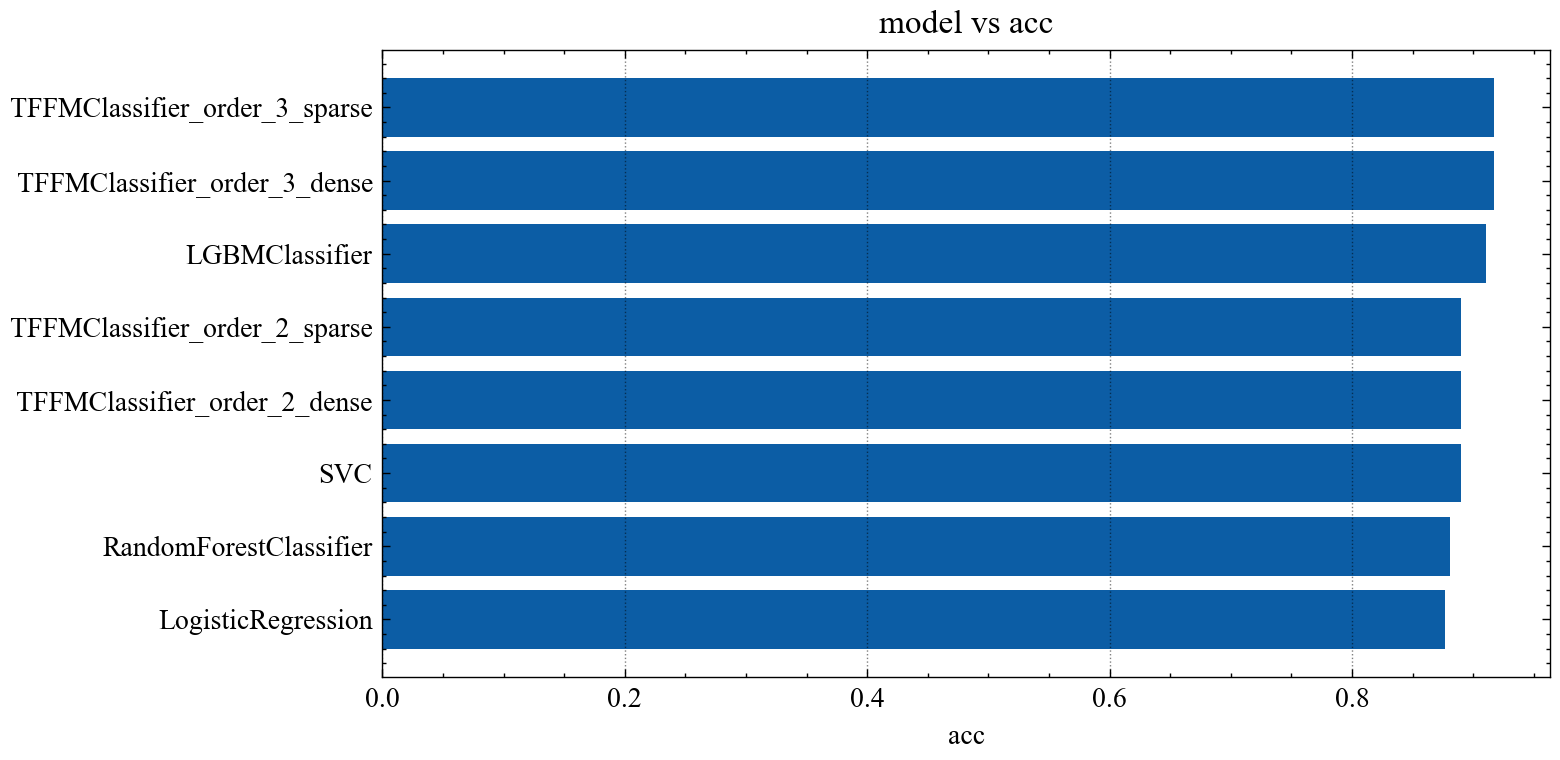

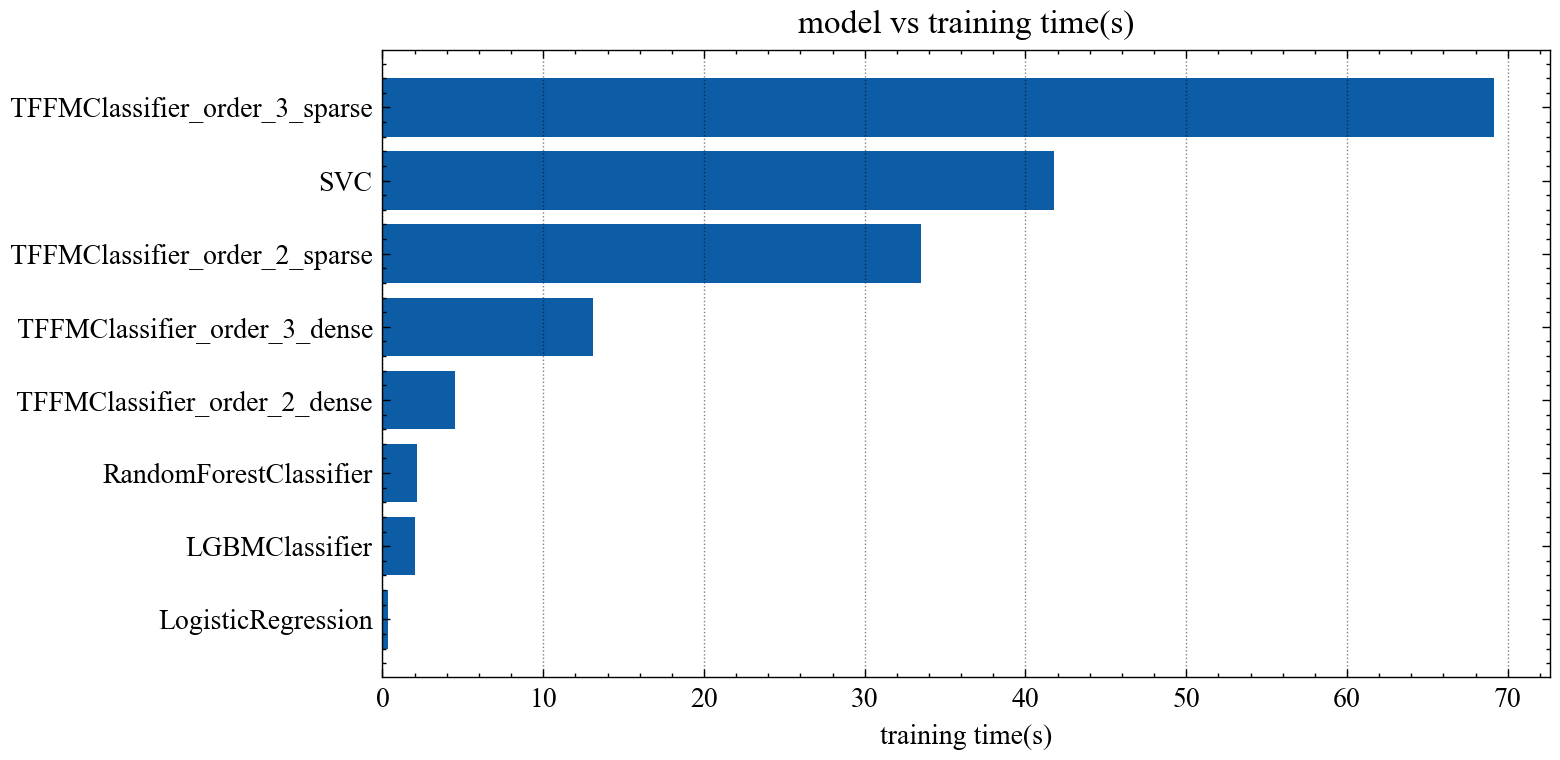

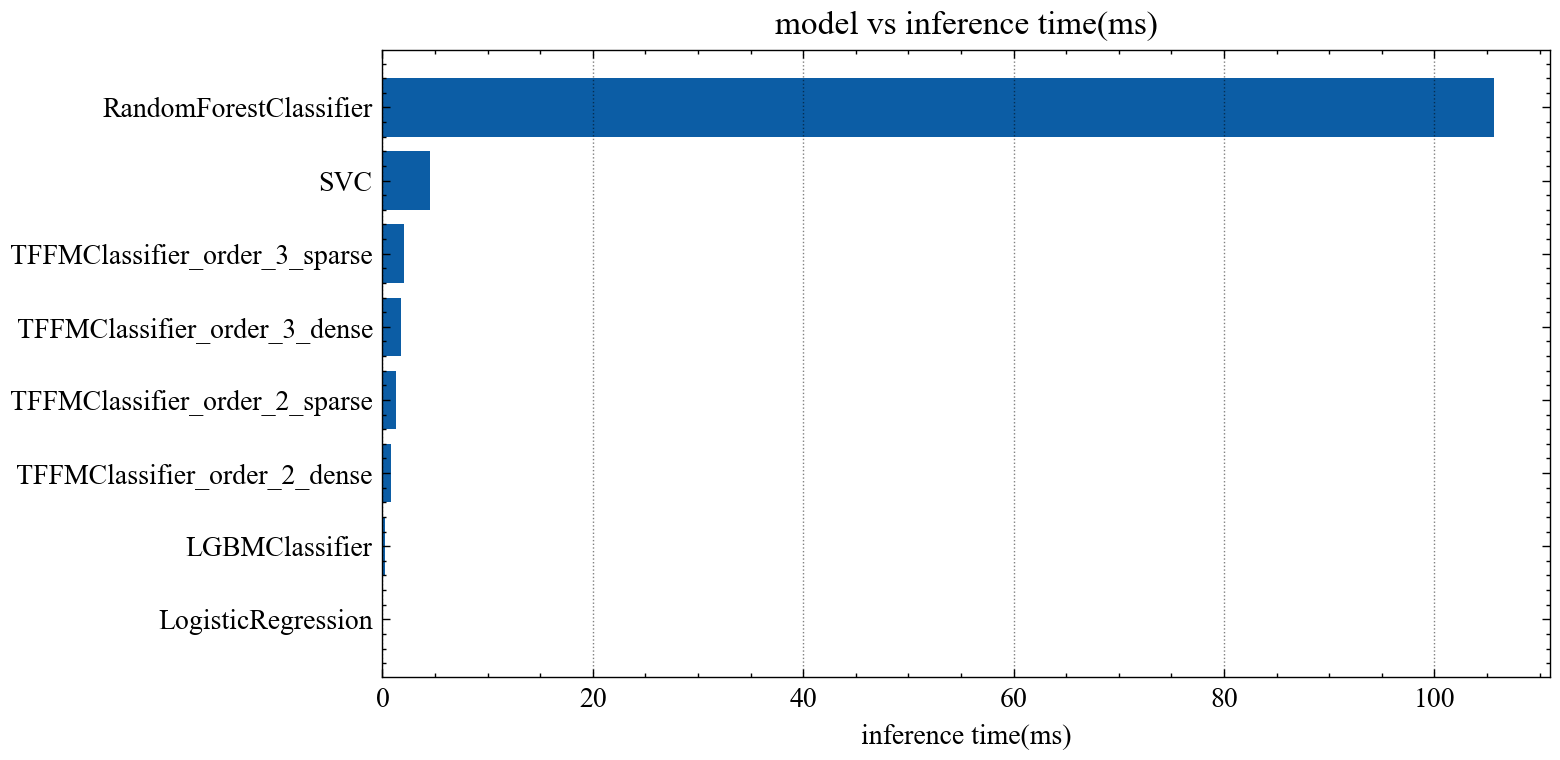

In [46]:
# plot
from matplotlib import pyplot as plt
import pandas as pd
benchmark_df = pd.DataFrame(benchmark_dict)
print(benchmark_dict.keys())
def plot_barh(df, x, y, is_saved = False, save_path='.'):
    sorted_df = df.sort_values(y,ascending=True)
    with plt.style.context(['science', 'grid', 'no-latex']):
        fig, ax = plt.subplots(figsize=(8,4),dpi=200)
        fig_title_name = f"{x} vs {y}"
        plt.barh(sorted_df[f'{x}'], sorted_df[f'{y}'])
        plt.xlabel(y)
        # No need, self document by category
        # plt.ylabel
        plt.title(fig_title_name)
        plt.grid(axis='y')
        plt.tight_layout()
        if is_saved:
            plt.savefig(os.path.join(save_path,f'{fig_title_name}.png'))
        plt.show()

plot_barh(benchmark_df, x='model', y='acc',is_saved=False)
plot_barh(benchmark_df, x='model', y='training time(s)',is_saved=False)
plot_barh(benchmark_df, x='model', y='inference time(ms)',is_saved=False)

# Regression example

In [7]:
# from tffm import TFFMRegressor
# from sklearn.metrics import mean_squared_error

# model = TFFMRegressor(
#     order=order, 
#     rank=10, 
#     optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
#     n_epochs=50, 
#     batch_size=1024,
#     init_std=0.001,
#     reg=0.01,
#     input_type='sparse'
# )
# # translate Y from {0,1} to {-10, 10}
# model.fit(X_tr_sparse, y_tr*20-10, show_progress=True)
# predictions = model.predict(X_te_sparse)
# print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions > 0)))
# print('MSE: {}'.format(mean_squared_error(y_te*20-10, predictions)))
# model.destroy()

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 50/50 [00:18<00:00,  2.68epoch/s]


[order=3] accuracy: 0.8779799247176914
MSE: 53.18007707733002


# n_features/time complexity

In [50]:
n_features = X_all.shape[1]
used_features = range(100, 1000, 100)
n_repeats = 5
elapsed_mean = []
elapsed_std = []
model_title = ''

for cur_n_feats in tqdm(used_features):
    time_observation = []
    for _ in range(n_repeats):
        active_features = np.random.choice(range(n_features), size=cur_n_feats)
        model = TFFMClassifier(
                    order=2, 
                    rank=100,
                    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                    n_epochs=1, 
                    batch_size=-1,
                    init_std=0.01,
                    input_type='dense'
        )
        model_title = model.__str__()
        # manually initialize model without calling .fit()
        model.core.set_num_features(cur_n_feats)
        model.core.build_graph()
        model.initialize_session()
        
        start_time = time()
        predictions = model.decision_function(X_all[:, active_features])
        end_time = time()
        model.destroy()
        time_observation.append(end_time - start_time)
    elapsed_mean.append(np.mean(time_observation))
    elapsed_std.append(np.std(time_observation))

100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Populating the interactive namespace from numpy and matplotlib


/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


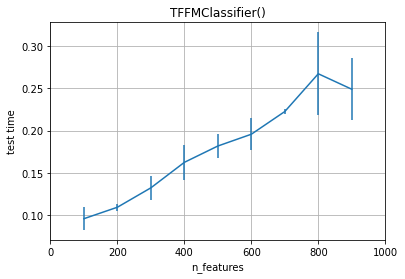

In [51]:
%pylab inline
errorbar(used_features, elapsed_mean, yerr=elapsed_std)
xlim(0, 1000)
title(model_title)
xlabel('n_features')
ylabel('test time')
grid()

# Logging example

In [10]:
# order = 3
# model = TFFMClassifier(
#     order=order, 
#     rank=10, 
#     optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
#     n_epochs=10, 
#     batch_size=-1,
#     init_std=0.001,
#     reg=0.001,
#     input_type='sparse',
#     log_dir='./tmp/logs',
#     verbose=1
# )
# model.fit(X_tr_sparse, y_tr, show_progress=True)
# predictions = model.predict(X_te_sparse)
# print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions)))

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


  0%|          | 0/10 [00:00<?, ?epoch/s]

Initialize logs, use: 
tensorboard --logdir=/Users/YuLong/Desktop/Working_Area/recsys_im/tffm/yltsai/tmp/logs


100%|██████████| 10/10 [00:03<00:00,  2.74epoch/s]


[order=3] accuracy: 0.8701380175658721


# Save/load example

In [11]:
# # 可用!
# model.save_state('./tmp/state.tf')
# model.destroy()

In [12]:
# model = TFFMClassifier(
#     order=3, 
#     rank=10, 
#     optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
#     n_epochs=10, 
#     batch_size=-1,
#     init_std=0.001,
#     reg=0.001,
#     input_type='sparse',
#     log_dir='./tmp/logs',
#     verbose=1
# )

# # internally model need to allocate memory before load previous weights,
# # so need to set num_features explicitly
# model.core.set_num_features(X_tr.shape[1])
# model.load_state('./tmp/state.tf')

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Initialize logs, use: 
tensorboard --logdir=/Users/YuLong/Desktop/Working_Area/recsys_im/tffm/yltsai/tmp/logs
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/state.tf


# Tuning latent factors/optimizer/regularization/class weights

* TODO add a latent factor tuning


## Different optimizers

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


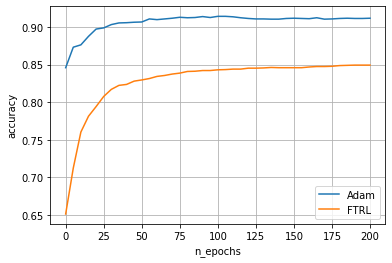

In [13]:
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=optim,
        batch_size=1024,
        init_std=0.001,
        reg=0.1,
        input_type='sparse',
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend()
grid()

## Different regularization strategies

In [14]:
X_all = np.vstack([
    mnist_images[mnist_labels==3,:],
    mnist_images[mnist_labels==5,:]
])

y_all = np.array([1]*n_three + [0]*n_five)

# make it more sparse (sparseness is about 97%)
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.97)

print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {}'.format(np.mean(X_all != 0)))
print('Classes balance: {} / {}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

Dataset shape: (10625, 784)
Non-zeros rate: 0.006013565426170468
Classes balance: 0.46936470588235296 / 0.5306352941176471


/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.


/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


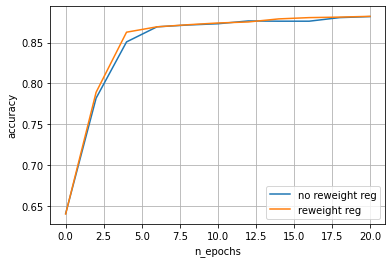

In [15]:
for use_reweight, title in [(False, 'no reweight reg'), (True, 'reweight reg')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
        batch_size=1024,
        init_std=0.001,
        reg=1.0,
        input_type='sparse',
        reweight_reg = use_reweight
    )
    n_epochs = 2
    anchor_epochs = range(0, 20+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend(loc=4)
grid()

## Weighted Loss Function

When using `TFFMClassifier`, one can set the parameter `sample_weights` in order to 

1. Use a "balanced" weighting scheme, in which the weight applied to the positive class is $w_+ = n_- / n_+$.
2. Prove a custom weight that is applied to every sample from the positive class.
2. Prove arbitrary weights to be applied to each sample.

We will demonstrate the first two approaches.

In [16]:
from sklearn.metrics import confusion_matrix

# generate imbalanced data:
X_imbalanced = X_all[4000:,:]
y_imbalanced = y_all[4000:]

print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(y_imbalanced==0), 
                                                  np.mean(y_imbalanced==1)))

print('Balanced positive weight is {:.03f}.'.format(np.mean(y_imbalanced==0)/np.mean(y_imbalanced==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_imbalanced, y_imbalanced, random_state=42, test_size=0.3)

Classes balance: 0.753 / 0.247
Balanced positive weight is 3.045.


In [17]:
# use default weighting
model = TFFMClassifier(
    order=2,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()  

100%|██████████| 50/50 [00:01<00:00, 31.84epoch/s]


accuracy: 0.7429577464788732


In [18]:
confusion_matrix(y_te,predictions)

array([[1405,   64],
       [ 447,   72]])

Unweighted loss shows good performance on prevalent class, but poor performance on class with smaller representation

In [19]:
# use balanced weighting
model = TFFMClassifier(
    order=2,
    sample_weight='balanced',
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

100%|██████████| 50/50 [00:01<00:00, 32.83epoch/s]


accuracy: 0.7253521126760564


In [20]:
confusion_matrix(y_te,predictions)

array([[1178,  291],
       [ 255,  264]])

Performance in underrepresented class improved, at the cost of performance in prevalent class.

In [21]:
# use manully weighting for positive class
model = TFFMClassifier(
    order=2,
    pos_class_weight=6.0,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()  

100%|██████████| 50/50 [00:01<00:00, 32.96epoch/s]


accuracy: 0.5025150905432596


In [22]:
confusion_matrix(y_te,predictions)

array([[528, 941],
       [ 48, 471]])

Here we've overdone it, but we're quite accurate on the underrepresented class. The limiting case will cause the classifier to put all point into the over-weighted class.

# Class Exploration